## Nadam v ADAM - Logistic regression on MNIST dataset.

In [14]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import math
import csv
import time

### Read MNIST data.

In [15]:
# X_test = np.genfromtxt('data/X_test.csv', delimiter = ',')
# y_test = np.genfromtxt('data/y_test.csv', delimiter = ',')
# X_train = np.genfromtxt('data/X_train.csv', delimiter = ',')
# y_train = np.genfromtxt('data/y_train.csv', delimiter = ',')
# data = np.genfromtxt('data/mnist_train_100.csv', delimiter = ',')
# data1 = np.genfromtxt('data/mnist_test_10.csv', delimiter = ',')
data = np.genfromtxt('data/mnist_train.csv', delimiter = ',')
data1 = np.genfromtxt('data/mnist_test.csv', delimiter = ',')
X_train = data[:, 1:]/256.0
y_train = data[:, 0]
X_test = data1[:, 1:]/256.0
y_test = data1[:, 0]

### Calculate gradient for the negative log likelihood loss function

In [16]:
def grad_calc(beta, X, y, C, mu = 0.5):
    #t1 = time.time()
    N = X.shape[0]
    n = X.shape[1]
    acc1 = np.zeros([C*n, 1])
    acc2 = np.zeros([C*n, 1]) 
    for i in range(N):
        X_i = X[i,:]
        X_i = np.reshape(X_i, [n,1])
        X_i_t  = np.transpose(X_i)
        acc1[int((y[i])*n):int((y[i]+1)*n)] = acc1[int((y[i])*n):int((y[i]+1)*n)] + X_i
        den = 0
        num = np.zeros([C*n, 1])
        for j in range(C):
            exp_term = math.exp(-np.dot(X_i_t, beta[j*n:(j+1)*n]))
            den = den + exp_term
            #num[j*n:(j+1)*n] = num[j*n:(j+1)*n] - m.exp(-np.dot(X[i,:], beta[j*n:(j+1)*n]))*X_i
            num[j*n:(j+1)*n] = num[j*n:(j+1)*n] - exp_term*X_i
        acc2 = acc2 + num/den
    grad = 1.0/N*(acc1+acc2) + 2*mu*beta
   # t2 = time.time()
    #print "gradient step time", t2 - t1
    return grad
    

### Perform one step of Gradient Descent

In [17]:
def gradient_descent(beta, X, y, C, mu):
    #t1 = time.time()
    grad = grad_calc(beta, X, y, C, mu)
    eeta = 1e-1
    beta = beta - eeta*grad
    #t2 = time.time()
    #print "gradient descent function time", t2-t1
    return beta

### Perform one descent step of ADAM

In [18]:
def adam(theta, m, v, beta1, beta2, alpha, t, X=0, y=0, regularize = 0, num_class=0):
    grad = grad_calc(theta, X, y, num_class, regularize)
    m = beta1*m + (1-beta1)*grad
    v = beta2*v + (1-beta2)*np.multiply(grad, grad)
    m_hat = m/(1 - beta1**t)
    v_hat = v/(1 - beta2**t)
    eps = 1e-8
    theta = theta - alpha*np.multiply(m, 1/(v**0.5 + eps))
    return theta, m, v

### Perform one descent step of NADAM

In [19]:
def nadam(theta, m, prod_mu, n, mu, nu, eta, t, X=0, y=0, regularize=0,num_class=0):
    grad = grad_calc(theta, X, y, num_class, regularize)
    mu_t = mu*(1 - 0.5*.96**(t/250))
    mu_t_1 = mu*(1 - 0.5*.96**((t+1)/250))
#     print mu_t, mu_t_1, t
    prod_mu = prod_mu*mu_t
    prod_mu_1 = prod_mu*mu_t_1
    g_hat = grad/(1-prod_mu)
    m = mu*m+(1-mu)*grad
    
    m_hat = m/(1-prod_mu_1)
    n = nu*n + (1-nu)*np.multiply(grad, grad)
    n_hat = n/(1-nu**t)
    m_bar = (1 - mu_t)*g_hat + mu_t_1*m_hat
    
    eps = 1e-8
    theta = theta - eta*np.multiply(m_bar, 1/(n_hat**0.5 + eps))
    return theta, prod_mu, m, n

### Optimization 

In [22]:
def descent(update, X, y, X_test, y_test, C, mu, t):
    N = X.shape[0]
    n = X.shape[1]
    N1 = X_test.shape[0]
    cost_test = []
    cost_train = []
    beta = np.zeros([C*n, 1])
    """
    Perform Gradient descent
    """
    if update == gradient_descent:
        for i in range(t):          
            beta = update(beta, X, y, C, mu)
            acc1 = 0
            acc2 = 0
            """
            Calculate Test Error
            """
            for j in range(N1):
                #print "j", j
                X_j_t = np.reshape(X_test[j,:], [1, n])
                acc1 = acc1+np.dot(X_j_t, beta[int(y_test[j]*n):int((y_test[j]+1)*n)])
                C_acc = 0
                for k in range(C):
#                     print np.dot(X_j_t, beta[k*n:(k+1)*n])
                    C_acc = C_acc + math.exp(-np.dot(X_j_t, beta[k*n:(k+1)*n]))
                acc2 = acc2 + math.log(C_acc)
        
            cost_t = 1.0/N1*(acc1+acc2) #+ mu*la.norm(beta)**2
            cost_test.append(cost_t)
            acc1 = 0
            acc2 = 0
            
            """
            Calculate Training Error
            """
            for j in range(N):
                X_j_t = np.reshape(X[j,:], [1, n])
                acc1 = acc1+np.dot(X_j_t, beta[int(y[j]*n):int((y[j]+1)*n)])
                C_acc = 0
                for k in range(C):
                    C_acc = C_acc + math.exp(-np.dot(X_j_t, beta[k*n:(k+1)*n]))
                acc2 = acc2 + math.log(C_acc)     
            cost_t = 1.0/N*(acc1+acc2) #+ mu*la.norm(beta)**2
            cost_train.append(cost_t)
   
    """
    Perform ADAM
    """
    if update == adam:
        m = 0
        v = 0
        beta1 = 0.9
        beta2 = 0.999
        alpha = 0.001
        for i in range(t):
#             print "i",i
            beta, m, v = adam(beta, m, v, beta1, beta2, alpha, i+1, X, y, mu, C)
            acc1 = 0
            acc2 = 0
            for j in range(N1):
                #print "j", j
                X_j_t = np.reshape(X_test[j,:], [1, n])
                acc1 = acc1+np.dot(X_j_t, beta[int(y_test[j]*n):int((y_test[j]+1)*n)])
                C_acc = 0
                for k in range(C):
#                     print np.dot(X_j_t, beta[k*n:(k+1)*n])
                    C_acc = C_acc + math.exp(-np.dot(X_j_t, beta[k*n:(k+1)*n]))
                acc2 = acc2 + math.log(C_acc)

            cost_t = 1.0/N1*(acc1+acc2) #+ mu*la.norm(beta)**2
            cost_test.append(cost_t)
            acc1 = 0
            acc2 = 0
            for j in range(N):
                X_j_t = np.reshape(X[j,:], [1, n])
                acc1 = acc1+np.dot(X_j_t, beta[int(y[j]*n):int((y[j]+1)*n)])
                C_acc = 0
                for k in range(C):
                    C_acc = C_acc + math.exp(-np.dot(X_j_t, beta[k*n:(k+1)*n]))
                acc2 = acc2 + math.log(C_acc)     
            cost_t = 1.0/N*(acc1+acc2) #+ mu*la.norm(beta)**2
            cost_train.append(cost_t)
    """
    Perform NADAM
    """
    if update == nadam:
        m = 0
        n1 = 0
        beta1 = 0.99
        nu = 0.999
        prod_mu = 1
        eta = 0.005
        for i in range(t):
#             print "i",i
            beta, prod_mu, m, n1 = nadam(beta, m, prod_mu, n1, beta1, nu, eta, i+1, X, y, mu,C)
            acc1 = 0
            acc2 = 0
            for j in range(N1):
                #print "j", j
                X_j_t = np.reshape(X_test[j,:], [1, n])
                acc1 = acc1+np.dot(X_j_t, beta[int(y_test[j]*n):int((y_test[j]+1)*n)])
                C_acc = 0
                for k in range(C):
#                     print np.dot(X_j_t, beta[k*n:(k+1)*n])
                    C_acc = C_acc + math.exp(-np.dot(X_j_t, beta[k*n:(k+1)*n]))
                acc2 = acc2 + math.log(C_acc)

            cost_t = 1.0/N1*(acc1+acc2) #+ mu*la.norm(beta)**2
            cost_test.append(cost_t)
            acc1 = 0
            acc2 = 0
            for j in range(N):
                X_j_t = np.reshape(X[j,:], [1, n])
                acc1 = acc1+np.dot(X_j_t, beta[int(y[j]*n):int((y[j]+1)*n)])
                C_acc = 0
                for k in range(C):
                    C_acc = C_acc + math.exp(-np.dot(X_j_t, beta[k*n:(k+1)*n]))
                acc2 = acc2 + math.log(C_acc)     
            cost_t = 1.0/N*(acc1+acc2) #+ mu*la.norm(beta)**2
            cost_train.append(cost_t)
    return beta, cost_test, cost_train
            
        

3747.61400008


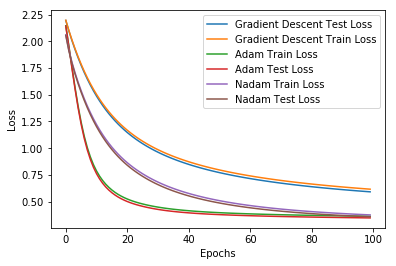

In [25]:
C = 10
mu = 1e-3
t = 100
t1 = time.time()

beta_gd, loss_gd_test, loss_gd_train = descent(gradient_descent, X_train, y_train, X_test, y_test, C, mu, t)
beta_adam, loss_adam_test, loss_adam_train = descent(adam, X_train, y_train, X_test, y_test, C, mu, t)
beta_nadam, loss_nadam_test, loss_nadam_train = descent(nadam, X_train, y_train, X_test, y_test, C, mu, t)

loss_gd_test = np.reshape(loss_gd_test, [t,1])
loss_adam_test = np.reshape(loss_adam_test, [t,1])
loss_nadam_test = np.reshape(loss_nadam_test, [t,1])

loss_gd_train = np.reshape(loss_gd_train, [t,1])
loss_adam_train = np.reshape(loss_adam_train, [t,1])
loss_nadam_train = np.reshape(loss_nadam_train, [t,1])

print time.time() - t1
plt.plot(loss_gd_test, label='Gradient Descent Test Loss')
plt.plot(loss_gd_train, label='Gradient Descent Train Loss')

plt.plot(loss_adam_train, label='Adam Train Loss')
plt.plot(loss_adam_test, label='Adam Test Loss')

plt.plot(loss_nadam_train, label='Nadam Train Loss')
plt.plot(loss_nadam_test, label='Nadam Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()